In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

In [2]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

DEVICE = get_device()
print(DEVICE)

cpu


In [3]:
filenames = os.listdir("Fruit-262/apple")
len(filenames)

1205

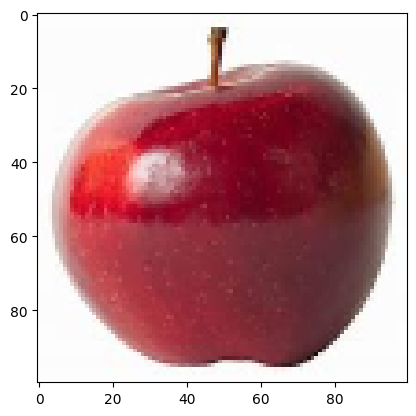

In [4]:
# from IPython import display
image = cv2.imread("Fruit-262/apple/1.jpg")
image = cv2.resize(image, dsize=(100, 100))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import glob
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_image(filename):
    try:
        image = cv2.imread(filename)
        if image is not None:
            image = cv2.resize(image, (100, 100))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            return image
        else:
            print(f"Failed to read image {filename}")
            return None
    except cv2.error as e:
        print(f"OpenCV error while processing {filename}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error while processing {filename}: {e}")
        return None

def load_images(path):
    images = []
    file_pattern = os.path.join(path, '*.jpg')
    filenames = glob.glob(file_pattern)

    with ThreadPoolExecutor(max_workers=8) as executor:
        future_to_filename = {executor.submit(process_image, filename): filename for filename in filenames}
        for future in tqdm(as_completed(future_to_filename), total=len(filenames)):
            result = future.result()
            if result is not None:
                images.append(result)

    return np.array(images)

In [6]:
apple_train = load_images("Fruit-262/apple/train")
mango_train = load_images("Fruit-262/mango/train")
banana_train = load_images("Fruit-262/banana/train")
orange_train = load_images("Fruit-262/orange/train")
grape_train = load_images("Fruit-262/grape/train")

apple_test = load_images("Fruit-262/apple/test")
mango_test = load_images("Fruit-262/mango/test")
banana_test = load_images("Fruit-262/banana/test")
orange_test = load_images("Fruit-262/orange/test")
grape_test = load_images("Fruit-262/grape/test")

100%|██████████| 500/500 [00:00<00:00, 1099.66it/s]


In [7]:
np.save('save_data/apple_train.npy', apple_train)
np.save('save_data/mango_train.npy', mango_train)
np.save('save_data/banana_train.npy', banana_train)
np.save('save_data/orange_train.npy', orange_train)
np.save('save_data/grape_train.npy', grape_train)

np.save('save_data/apple_train.npy', apple_test)
np.save('save_data/mango_test.npy', mango_test)
np.save('save_data/banana_test.npy', banana_test)
np.save('save_data/orange_test.npy', orange_test)
np.save('save_data/grape_test.npy', grape_test)

In [8]:
test = np.load(file="save_data/apple_train.npy")
test.shape

(500, 100, 100, 3)

In [9]:
x_train = np.concatenate((apple_train, banana_train, grape_train, mango_train, orange_train), axis=0)
x_test = np.concatenate((apple_test, banana_test, grape_test, mango_test, orange_test), axis=0)

print(x_train.shape,x_test.shape)

(2400, 100, 100, 3) (2400, 100, 100, 3)


In [10]:
y_train = np.array([0] * len(apple_train) + [1] * len(banana_train)+ [2] * len(grape_train)+ [3] * len(mango_train)+ [4] * len(orange_train))
y_test = np.array([0] * len(apple_test) + [1] * len(banana_test)+ [2] * len(grape_test)+ [3] * len(mango_test)+ [4] * len(orange_test))

print(y_train.shape)
print(y_test.shape)

(2400,)
(2400,)


In [11]:
def show_images(images, labels, start_index):
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 12))

    counter = start_index

    for i in range(4):
        for j in range(8):
            axes[i, j].set_title(labels[counter].item())
            axes[i, j].imshow(images[counter])
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)
            counter += 1
    plt.show()

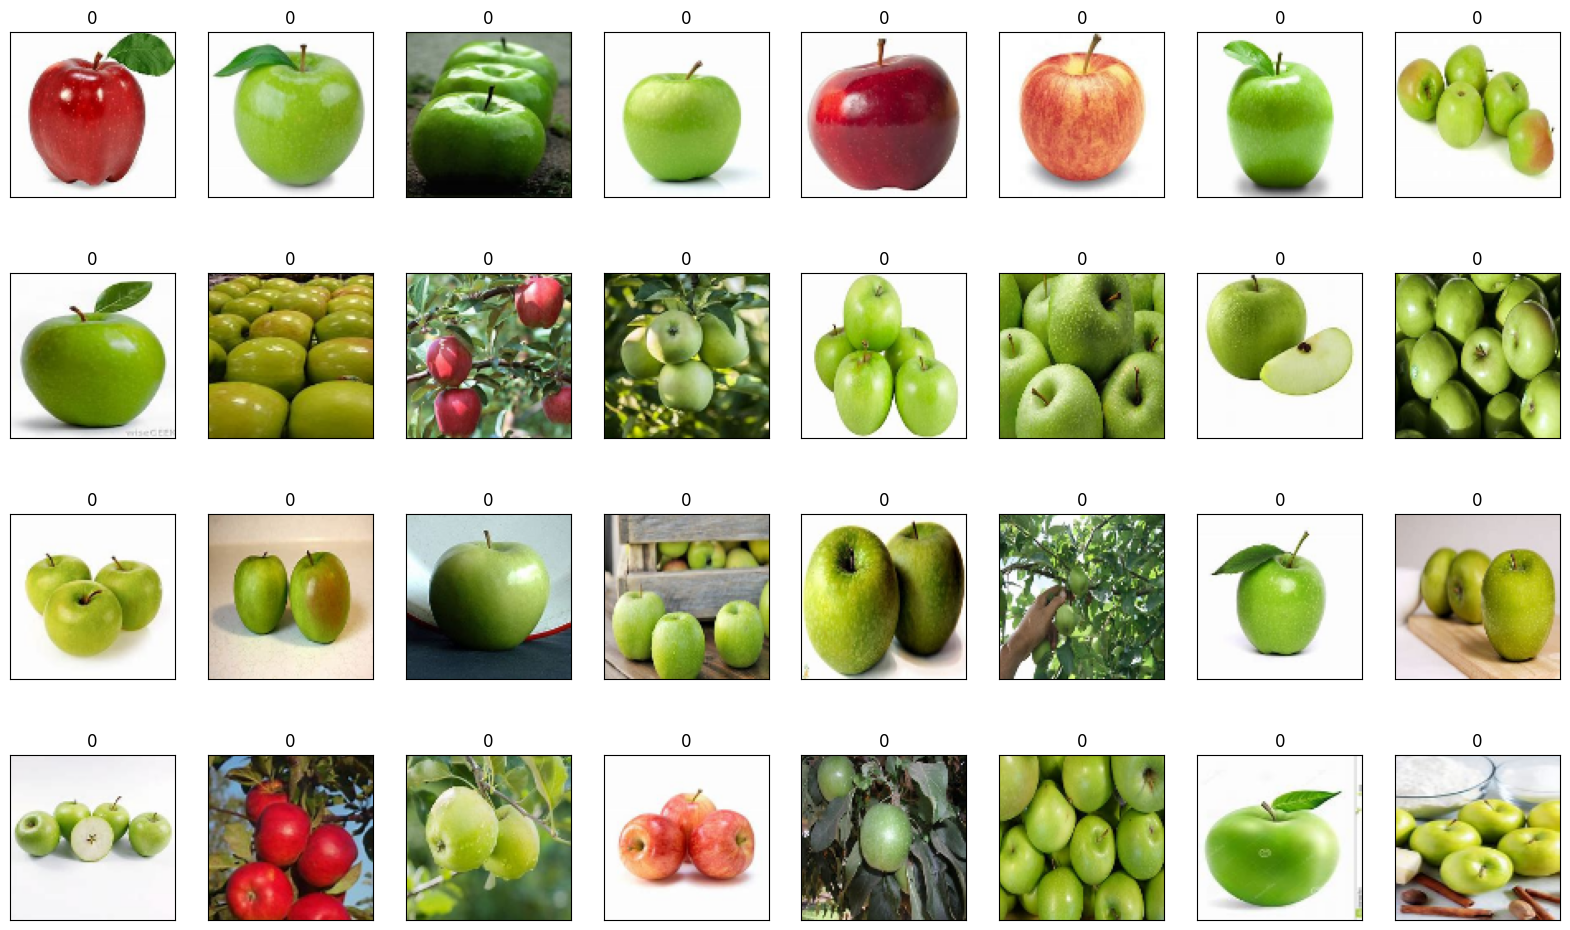

In [12]:
show_images(x_train, y_train, 0)

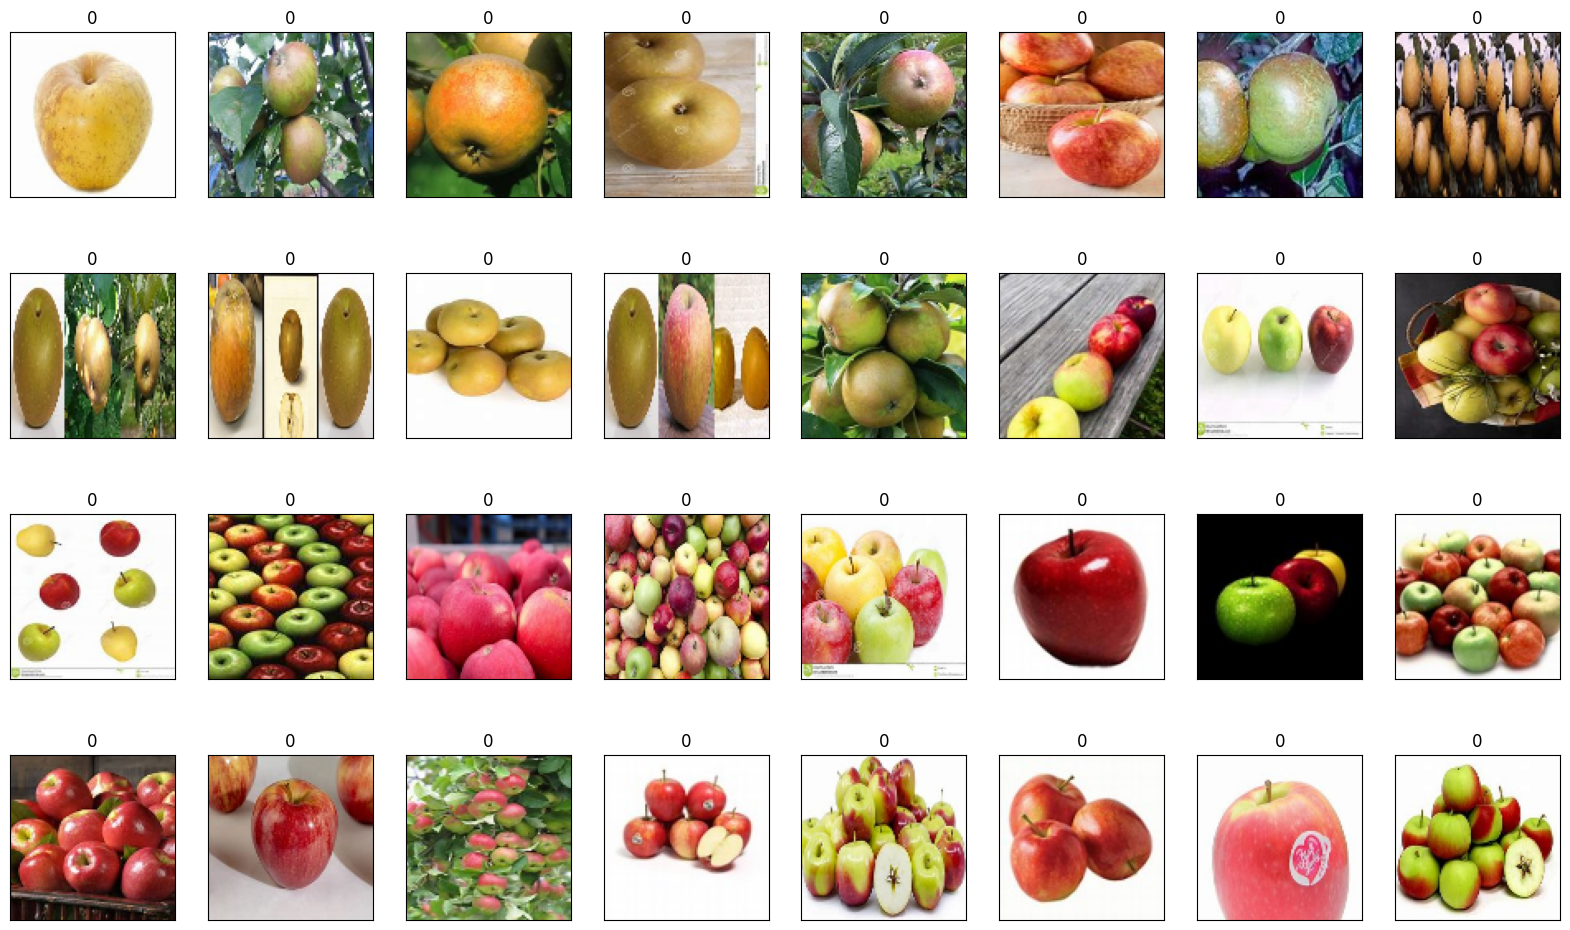

In [13]:
show_images(x_train, y_train, 200)

In [14]:
y_train = torch.from_numpy(y_train.reshape(-1, 1)) # -1 will get replaced with the number of rows
y_test = torch.from_numpy(y_test.reshape(len(y_test), 1))

print(y_train[:10])

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.int32)


In [15]:
transforms_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=20),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.005),
        transforms.RandomGrayscale(p=0.2),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

In [16]:
transforms_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

In [17]:
from torch.utils.data import Dataset

class FruitDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        super(FruitDataset, self).__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


In [18]:
print(len(x_train),len(x_test),len(y_test),len(y_train))

2400 2400 2400 2400


In [19]:

# Create the training and test datasets
train_dataset = FruitDataset(
    images=x_train, labels=y_train, transform=transforms_train
)
test_dataset = FruitDataset(
    images=x_test, labels=y_test, transform=transforms_test
)


In [20]:
len(train_dataset)

2400

In [21]:
len(test_dataset)

2400

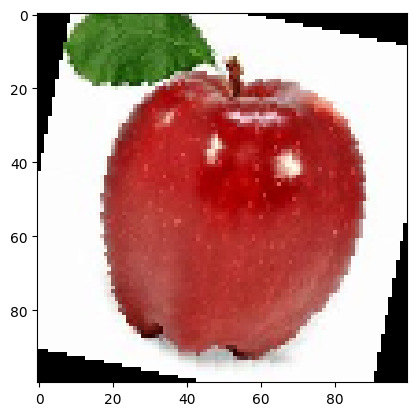

In [22]:
image, label = train_dataset[0]
# print(type(image), image)
plt.imshow((image.numpy() * (0.5) + 0.5).transpose(1, 2, 0))

In [23]:
print(len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

print(len(train_loader))

2400
75


In [24]:
iterator = iter(train_loader)
image_batch, label_batch = next(iterator)

print(image_batch.shape, label_batch.shape)

torch.Size([32, 3, 100, 100]) torch.Size([32, 1])


Original batch shapes: torch.Size([32, 3, 100, 100]) torch.Size([32, 1])
Permuted batch shape: torch.Size([32, 100, 100, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

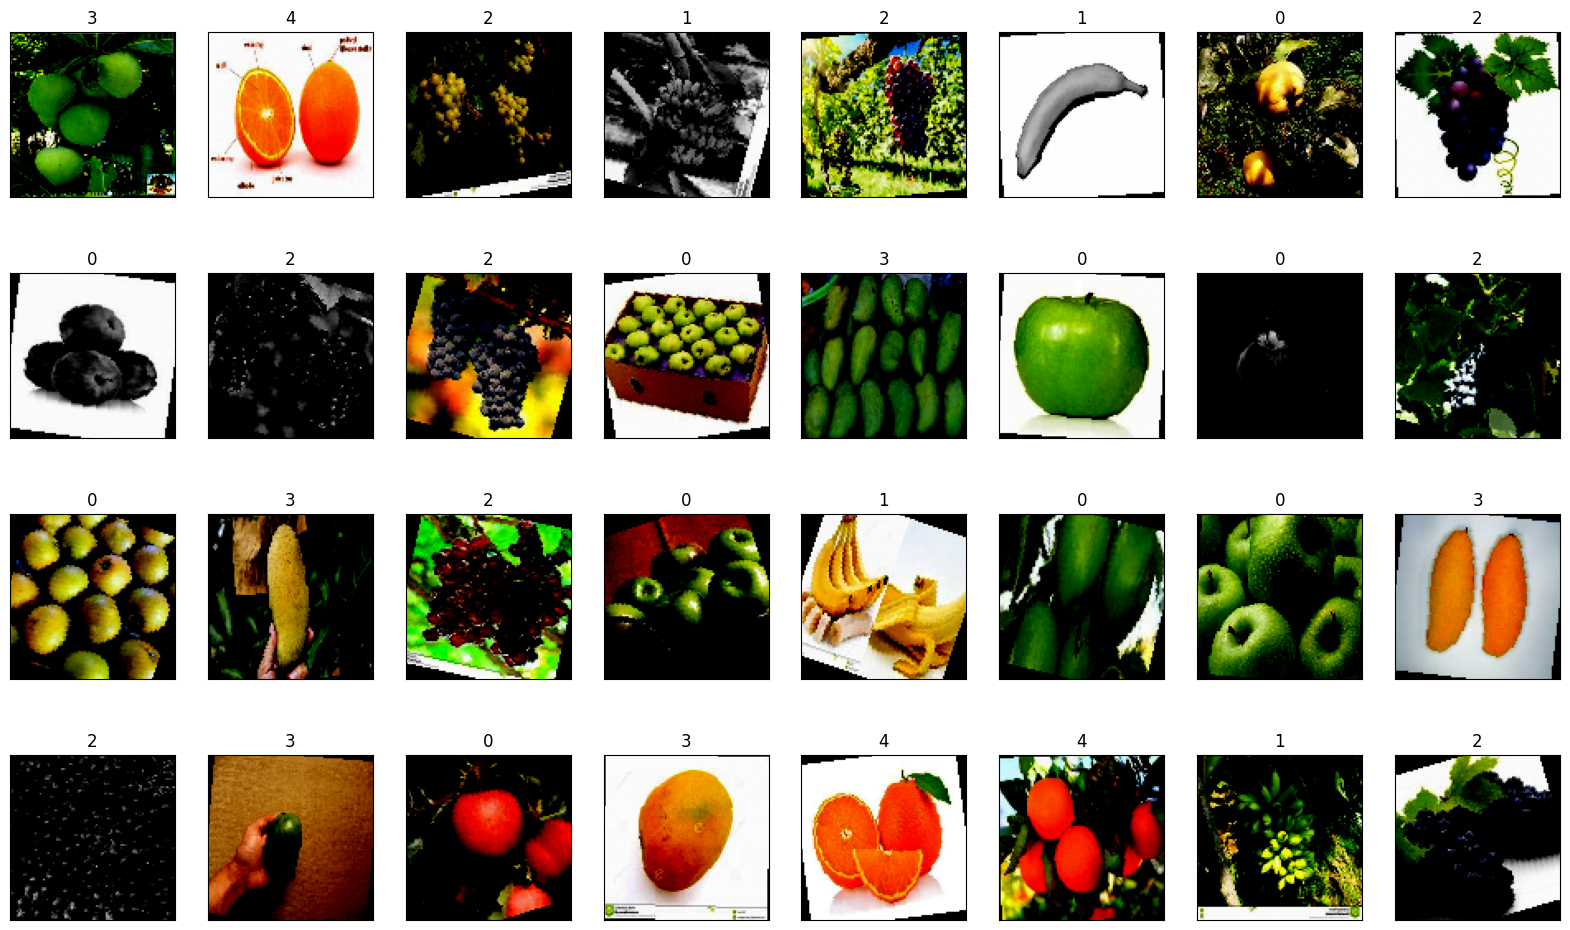

In [25]:
# Print the shapes of the image and label batches
print("Original batch shapes:", image_batch.shape, label_batch.shape)

# Permute the image batch from (batch_size, channels, height, width) to (batch_size, height, width, channels)
image_batch_permuted = image_batch.permute(0, 2, 3, 1)

# Print the shape after permutation
print("Permuted batch shape:", image_batch_permuted.shape)

# Function to show images (assuming show_images is defined elsewhere)
show_images(image_batch_permuted, label_batch, 0)

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn0 = nn.BatchNorm2d(num_features=16)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(num_features=32)

        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(num_features=64)

        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(num_features=128)

        # shape - > 32, 128, 6 , 6

        # self.dropout = nn.Dropout(p=0.5)
        self.fc0 = nn.Linear(in_features=128 * 6 * 6, out_features=64)
        self.fc1 = nn.Linear(in_features=64, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=9)  # Changed to output num_classes

    def forward(self, x):
        x = F.relu(self.bn0(self.conv0(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = x.reshape(x.shape[0], -1)

        x = F.leaky_relu(self.fc0(x))
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)  # No softmax here if using CrossEntropyLoss

        return x


In [27]:
import torch




model = CNN(9).to(DEVICE)
print(model)


CNN(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=4608, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)


In [28]:
random_input = torch.randn((32, 3, 100, 100)).to(DEVICE)

# Get the logits from the model
logits = model(random_input)

# If you need probabilities, apply softmax
probs = torch.softmax(logits, dim=1)

# Print the probabilities
print(probs)

tensor([[0.0771, 0.1026, 0.1282, 0.1310, 0.1130, 0.1300, 0.0790, 0.1078, 0.1313],
        [0.0845, 0.1020, 0.1208, 0.1328, 0.1171, 0.1256, 0.0819, 0.1095, 0.1258],
        [0.0767, 0.1022, 0.1305, 0.1274, 0.1092, 0.1277, 0.0867, 0.1167, 0.1227],
        [0.0744, 0.1008, 0.1292, 0.1241, 0.1058, 0.1356, 0.0886, 0.1140, 0.1274],
        [0.0791, 0.1087, 0.1240, 0.1221, 0.1129, 0.1322, 0.0835, 0.1076, 0.1298],
        [0.0866, 0.1045, 0.1306, 0.1241, 0.1062, 0.1313, 0.0892, 0.1083, 0.1193],
        [0.0837, 0.1014, 0.1252, 0.1280, 0.1075, 0.1325, 0.0895, 0.1061, 0.1262],
        [0.0832, 0.1030, 0.1193, 0.1337, 0.1087, 0.1333, 0.0869, 0.1153, 0.1166],
        [0.0896, 0.1099, 0.1204, 0.1218, 0.1051, 0.1299, 0.0899, 0.1108, 0.1226],
        [0.0822, 0.1091, 0.1200, 0.1191, 0.1140, 0.1380, 0.0815, 0.1073, 0.1287],
        [0.0701, 0.0944, 0.1197, 0.1393, 0.1162, 0.1313, 0.0805, 0.1200, 0.1285],
        [0.0876, 0.1116, 0.1246, 0.1184, 0.1090, 0.1255, 0.0903, 0.1118, 0.1212],
        [0.0835,

In [29]:
summary(model, input_size=(32, 3, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 9]                   --
├─Conv2d: 1-1                            [32, 16, 100, 100]        432
├─BatchNorm2d: 1-2                       [32, 16, 100, 100]        32
├─MaxPool2d: 1-3                         [32, 16, 50, 50]          --
├─Conv2d: 1-4                            [32, 32, 50, 50]          4,608
├─BatchNorm2d: 1-5                       [32, 32, 50, 50]          64
├─MaxPool2d: 1-6                         [32, 32, 25, 25]          --
├─Conv2d: 1-7                            [32, 64, 25, 25]          18,432
├─BatchNorm2d: 1-8                       [32, 64, 25, 25]          128
├─MaxPool2d: 1-9                         [32, 64, 12, 12]          --
├─Conv2d: 1-10                           [32, 128, 12, 12]         73,728
├─BatchNorm2d: 1-11                      [32, 128, 12, 12]         256
├─MaxPool2d: 1-12                        [32, 128, 6, 6]           --
├

In [30]:
# loss_function = nn.BCELoss()    # x log(x) + (1-x) log(1-x) -> log loss
# optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_function = nn.CrossEntropyLoss()

# Adam optimizer with learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_function = nn.CrossEntropyLoss()  # Suitable for multi-class classification


In [31]:

def predict_test_data(model, test_loader, loss_function, device):
    model.eval()
    num_correct = 0
    num_samples = 0
    test_loss_total = 0

 

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device).long()

            # Forward pass
            test_preds = model(X_test)
            test_probs=torch.softmax(test_preds, dim=1)
           # test_y=torch.argmax(test_probs, dim=1)
            test_loss = loss_function(test_probs, y_test.squeeze())

            test_loss_total += test_loss.item()

            # Get predicted class labels
            _, predicted_labels = torch.max(test_preds, 1)
            num_correct += (predicted_labels == y_test).sum().item()
            num_samples += y_test.size(0)

    test_acc = num_correct / num_samples
    average_test_loss = test_loss_total / len(test_loader)

    return average_test_loss, test_acc


In [32]:
y_train

tensor([[0],
        [0],
        [0],
        ...,
        [4],
        [4],
        [4]], dtype=torch.int32)

In [33]:
len(train_loader)

75

In [34]:


train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(30):
    num_correct_train = 0
    num_samples_train = 0
    train_loss_total = 0

    model.train()
    for batch, (X_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X_train = X_train.to(DEVICE)
        y_train = y_train.squeeze().to(DEVICE).long()  # Ensure labels are 1D and long

        # Forward pass
        train_preds = model(X_train)
        train_loss = loss_function(train_preds, y_train)
        train_loss_total += train_loss.item()

        # Calculate train accuracy
        _, predicted_labels = torch.max(train_preds, 1)
        num_correct_train += (predicted_labels == y_train).sum().item()
        num_samples_train += y_train.size(0)

        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    train_acc = num_correct_train / num_samples_train
    average_train_loss = train_loss_total / len(train_loader)  # This line calculates the average loss

    test_loss, test_acc = predict_test_data(model, test_loader, loss_function, DEVICE)

    train_losses.append(average_train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(
        f"Epoch: {epoch} \t|"
        f" Train loss: {np.round(average_train_loss, 3)} \t|"
        f" Test loss: {np.round(test_loss, 3)} \t|"
        f" Train acc: {np.round(train_acc, 2)} \t|"
        f" Test acc: {np.round(test_acc, 2)}"
    )


100%|██████████| 75/75 [00:18<00:00,  4.08it/s]


Epoch: 0 	| Train loss: 1.339 	| Test loss: 1.94 	| Train acc: 0.45 	| Test acc: 6.65


100%|██████████| 75/75 [00:17<00:00,  4.23it/s]


Epoch: 1 	| Train loss: 1.086 	| Test loss: 1.851 	| Train acc: 0.56 	| Test acc: 6.7


100%|██████████| 75/75 [00:17<00:00,  4.24it/s]


Epoch: 2 	| Train loss: 1.009 	| Test loss: 1.841 	| Train acc: 0.59 	| Test acc: 6.86


100%|██████████| 75/75 [00:17<00:00,  4.27it/s]


Epoch: 3 	| Train loss: 0.946 	| Test loss: 1.839 	| Train acc: 0.61 	| Test acc: 6.86


100%|██████████| 75/75 [00:17<00:00,  4.23it/s]


Epoch: 4 	| Train loss: 0.885 	| Test loss: 1.809 	| Train acc: 0.65 	| Test acc: 6.95


100%|██████████| 75/75 [00:17<00:00,  4.25it/s]


Epoch: 5 	| Train loss: 0.848 	| Test loss: 1.76 	| Train acc: 0.66 	| Test acc: 6.96


100%|██████████| 75/75 [00:17<00:00,  4.25it/s]


Epoch: 6 	| Train loss: 0.863 	| Test loss: 1.765 	| Train acc: 0.66 	| Test acc: 6.89


100%|██████████| 75/75 [00:18<00:00,  4.16it/s]


Epoch: 7 	| Train loss: 0.777 	| Test loss: 1.751 	| Train acc: 0.7 	| Test acc: 6.85


100%|██████████| 75/75 [00:17<00:00,  4.26it/s]


Epoch: 8 	| Train loss: 0.778 	| Test loss: 1.753 	| Train acc: 0.69 	| Test acc: 6.78


100%|██████████| 75/75 [00:18<00:00,  4.08it/s]


Epoch: 9 	| Train loss: 0.746 	| Test loss: 1.745 	| Train acc: 0.71 	| Test acc: 6.97


100%|██████████| 75/75 [00:17<00:00,  4.21it/s]


Epoch: 10 	| Train loss: 0.719 	| Test loss: 1.716 	| Train acc: 0.71 	| Test acc: 6.88


100%|██████████| 75/75 [00:17<00:00,  4.31it/s]


Epoch: 11 	| Train loss: 0.711 	| Test loss: 1.686 	| Train acc: 0.72 	| Test acc: 6.96


100%|██████████| 75/75 [00:17<00:00,  4.32it/s]


Epoch: 12 	| Train loss: 0.705 	| Test loss: 1.723 	| Train acc: 0.72 	| Test acc: 6.89


100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


Epoch: 13 	| Train loss: 0.673 	| Test loss: 1.713 	| Train acc: 0.74 	| Test acc: 7.04


100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


Epoch: 14 	| Train loss: 0.62 	| Test loss: 1.709 	| Train acc: 0.75 	| Test acc: 6.96


100%|██████████| 75/75 [00:17<00:00,  4.25it/s]


Epoch: 15 	| Train loss: 0.615 	| Test loss: 1.703 	| Train acc: 0.75 	| Test acc: 7.06


100%|██████████| 75/75 [00:17<00:00,  4.36it/s]


Epoch: 16 	| Train loss: 0.604 	| Test loss: 1.702 	| Train acc: 0.77 	| Test acc: 6.94


100%|██████████| 75/75 [00:17<00:00,  4.31it/s]


Epoch: 17 	| Train loss: 0.583 	| Test loss: 1.707 	| Train acc: 0.78 	| Test acc: 7.0


100%|██████████| 75/75 [00:17<00:00,  4.35it/s]


Epoch: 18 	| Train loss: 0.561 	| Test loss: 1.7 	| Train acc: 0.79 	| Test acc: 7.09


100%|██████████| 75/75 [00:17<00:00,  4.31it/s]


Epoch: 19 	| Train loss: 0.584 	| Test loss: 1.682 	| Train acc: 0.78 	| Test acc: 6.84


100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


Epoch: 20 	| Train loss: 0.579 	| Test loss: 1.701 	| Train acc: 0.78 	| Test acc: 6.99


100%|██████████| 75/75 [00:17<00:00,  4.33it/s]


Epoch: 21 	| Train loss: 0.566 	| Test loss: 1.648 	| Train acc: 0.78 	| Test acc: 7.05


100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


Epoch: 22 	| Train loss: 0.53 	| Test loss: 1.643 	| Train acc: 0.8 	| Test acc: 6.87


100%|██████████| 75/75 [00:17<00:00,  4.30it/s]


Epoch: 23 	| Train loss: 0.535 	| Test loss: 1.65 	| Train acc: 0.8 	| Test acc: 7.0


100%|██████████| 75/75 [00:17<00:00,  4.35it/s]


Epoch: 24 	| Train loss: 0.506 	| Test loss: 1.634 	| Train acc: 0.8 	| Test acc: 6.99


100%|██████████| 75/75 [00:17<00:00,  4.39it/s]


Epoch: 25 	| Train loss: 0.472 	| Test loss: 1.659 	| Train acc: 0.82 	| Test acc: 6.9


100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


Epoch: 26 	| Train loss: 0.467 	| Test loss: 1.64 	| Train acc: 0.82 	| Test acc: 6.97


100%|██████████| 75/75 [00:17<00:00,  4.35it/s]


Epoch: 27 	| Train loss: 0.467 	| Test loss: 1.652 	| Train acc: 0.83 	| Test acc: 7.04


100%|██████████| 75/75 [00:17<00:00,  4.32it/s]


Epoch: 28 	| Train loss: 0.456 	| Test loss: 1.62 	| Train acc: 0.83 	| Test acc: 7.02


100%|██████████| 75/75 [00:18<00:00,  4.06it/s]


Epoch: 29 	| Train loss: 0.415 	| Test loss: 1.628 	| Train acc: 0.85 	| Test acc: 7.06


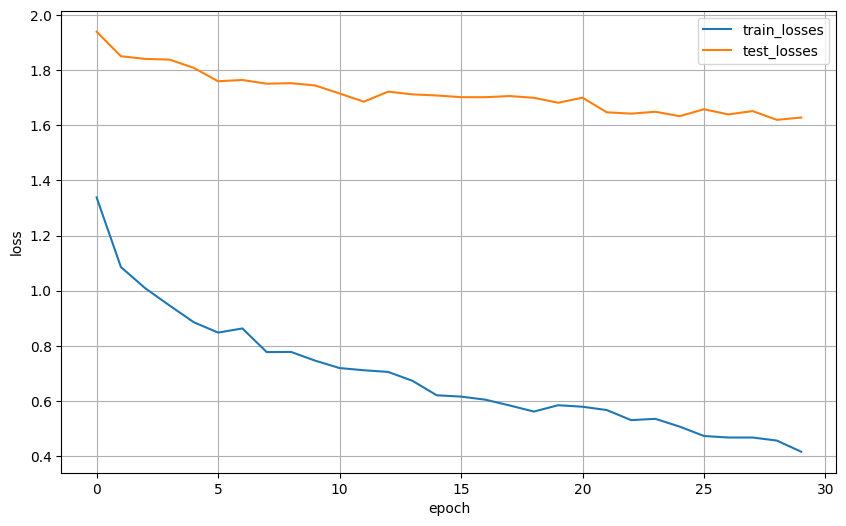

In [37]:
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(["train_losses", "test_losses"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

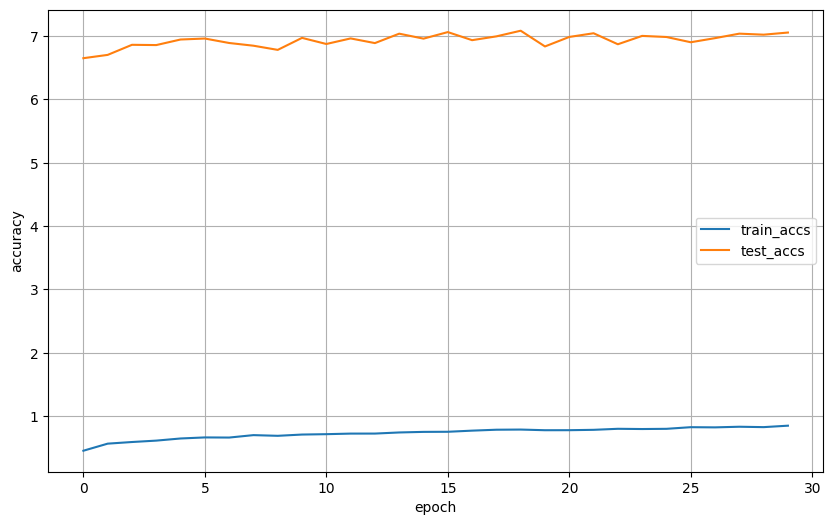

In [38]:
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(["train_accs", "test_accs"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([3, 2, 2, 1, 1, 1, 0, 4, 0, 3, 4, 0, 1, 1, 2, 4, 1, 4, 1, 4, 2, 1, 2, 1,
        0, 4, 4, 0, 3, 3, 0, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

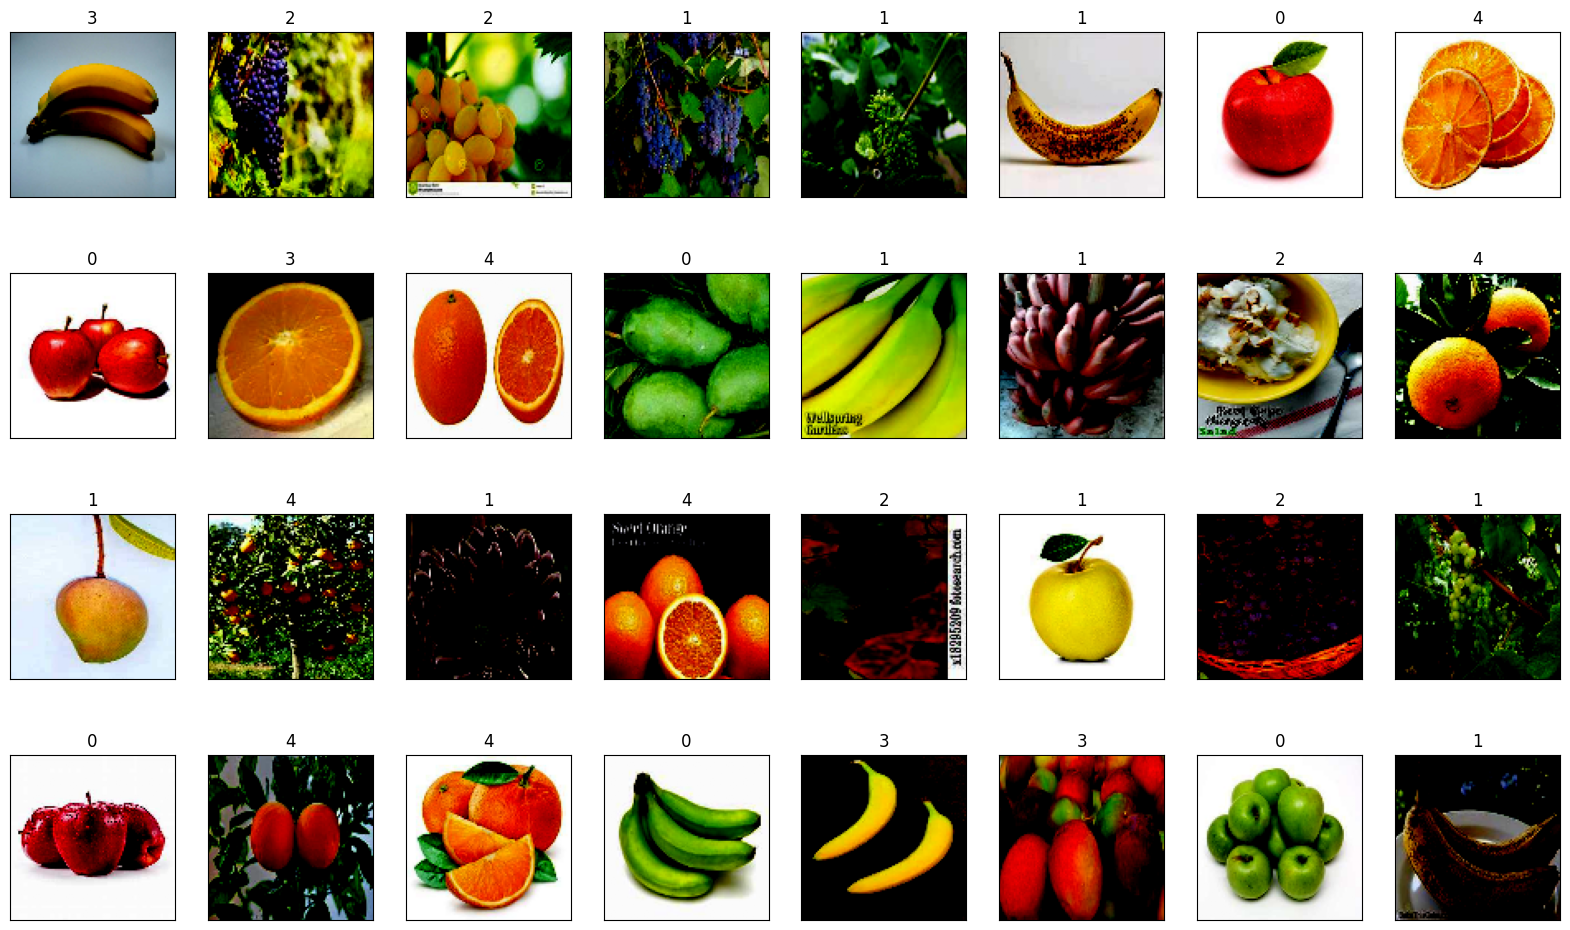

In [43]:
# Load test images/
iter_test = iter(test_loader)
img_test, lbl_test = next(iter_test)

# Predict labels
preds_test = model(img_test.to(DEVICE))
img_test_permuted = img_test.permute(0, 2, 3, 1)
rounded_preds = preds_test.argmax(dim=1)

print(rounded_preds)

# Show test images and the predicted labels
show_images(img_test_permuted, rounded_preds, 0)

In [40]:
torch.save(model, 'fruits.pt') # extensions -> .pt or .pth
pretrained_model = torch.load('fruits.pt').to(DEVICE)

C:\Users\Shaunak\AppData\Local\Temp\ipykernel_26272\1588404423.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model = torch.load('fruits.pt').to(DEVICE)


tensor([3, 1, 4, 2, 1, 4, 4, 1, 0, 4, 1, 2, 0, 0, 2, 0, 4, 3, 0, 1, 1, 3, 3, 4,
        2, 1, 2, 0, 3, 1, 3, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

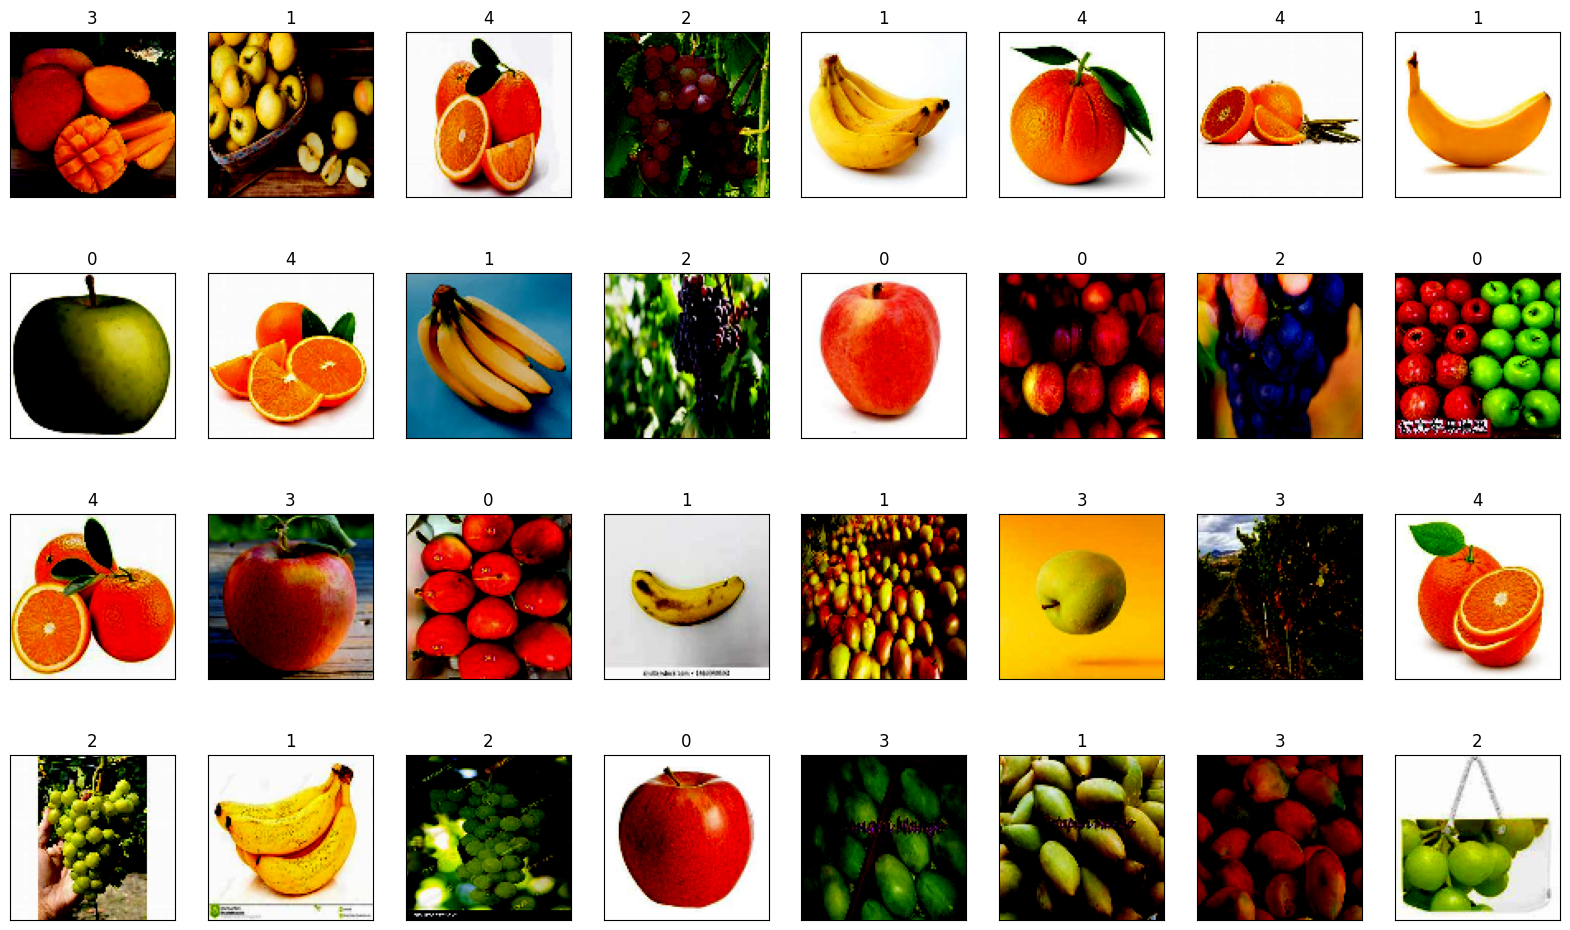

In [44]:
# Load test images/
iter_test = iter(test_loader)
img_test, lbl_test = next(iter_test)

# Predict labels
preds_test = pretrained_model(img_test.to(DEVICE))
img_test_permuted = img_test.permute(0, 2, 3, 1)
rounded_preds = preds_test.argmax(dim=1)

print(rounded_preds)

# Show test images and the predicted labels
show_images(img_test_permuted, rounded_preds, 0)